## EECS 531 - A2 - E2
### Tristan Maidment - tdm47

#### Goal
The goal for this experiment is the create a various band pass filters, and implement the DCT transform.

In [1]:
%matplotlib inline
import numpy as np
import math
import cv2
from matplotlib import pyplot as plt

#### Implementation
We will be using the following image for the purpose of this exercise.  I ensure that the image is normalized between `0. - 1.`, instead of using integers.

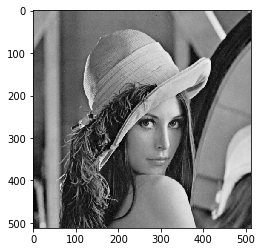

In [2]:
img = cv2.imread('./Lena.png', cv2.COLOR_BGR2GRAY)
gray = np.float32(img)/255.0
plt.imshow(gray, cmap = 'gray')
plt.show()

Using the built in DCT function provided by OpenCV2, we are able to convert the image to the frequency domain.  The higher intensity basis functions are represented by a purple pixel, while the lower intensity basis functions are represneted by a blue pixel.

The majority of the intensities are located at the lower frequency basis functions, generally lower than approximately 40.  As the frequency increases, the intensities are generally lower.

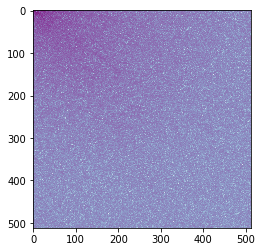

In [3]:
dct_img = cv2.dct(gray)
plt.imshow(np.log(np.absolute(dct_img)), cmap='BuPu')
plt.show()

The first goal is to implement a low pass filter.  This will be done by zeroing out the higher frequency basis functions.  Since the majority of the intensities are less than 40, we will try and create a `40x40` square of frequencies that "pass" through.

I have provided a visualization of the frequencies that are passed, and the resulting image below.

Note that using the command `lowPass[40:,40:] = 0` will not work due to how python handles it.  It will zero out a majority of high frequency basis functions, but will still keep a thin strip of high frequencies along the `X < 40` and `Y < 40`.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


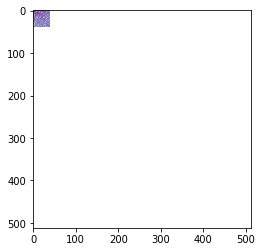

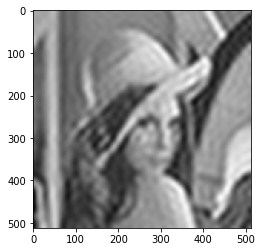

In [4]:
lowPass = dct_img.copy()
lowPass[:, 40:] = 0
lowPass[40:, :] = 0
#lowPass[40:,40:] = 0 #THIS DOES NOT WORK
plt.imshow(np.log(np.absolute(lowPass)), cmap='BuPu')
plt.show()
lowPass_img = cv2.idct(lowPass)
plt.imshow(lowPass_img, cmap = 'gray')
plt.show()

Similarly, a high pass filter can be implemented by removing the lower frequency basis functions from the transform.  This must be done in one line, or we lose higher frequencies with `X < 80` and `Y < 80`.  I chose 80 for purposes of reconstructing the image later in the exercise.

Again, the DCT transform and resulting image are visualized.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


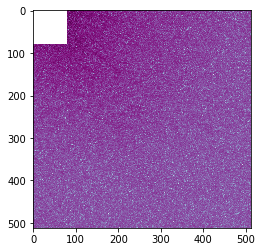

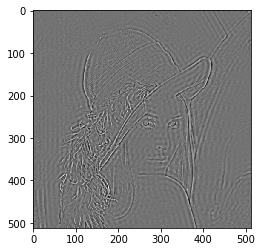

In [5]:
highPass = dct_img.copy()
highPass[:80, :80] = 0
plt.imshow(np.log(np.absolute(highPass)), cmap='BuPu')
plt.show()
highPass_img = cv2.idct(highPass)
plt.imshow(highPass_img, cmap = 'gray')
plt.show()

Now, that both a high and low pass filter have been defined, let us create a band pass filter.  This band pass filter will zero out the areas both allowed by the high pass and low pass filters, providing a "band" of frequencies to pass through.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


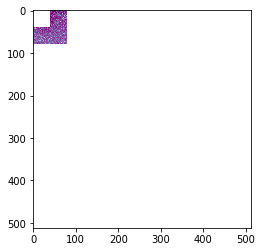

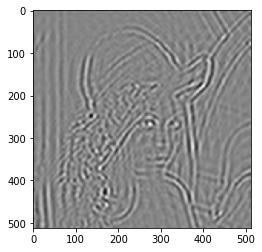

In [6]:
medPass = np.zeros(dct_img.shape)
medPass[:80, :80] = dct_img[:80, :80]
medPass[:40, :40] = 0
plt.imshow(np.log(np.absolute(medPass)), cmap='BuPu')
plt.show()
medPass_img = cv2.idct(medPass)
plt.imshow(medPass_img, cmap = 'gray')
plt.show()

Now that we have three filters each that allows seperate ranges of frequencies to pass through, we can combine the *resulting* images together to get the original image.  This is due to the fact that they are effectively combining all the frequencies together again.  This can be done without doing another inverse discrete transform due to the communiative property.

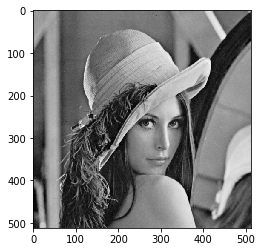

In [7]:
plt.imshow(lowPass_img + medPass_img + highPass_img, cmap = 'gray')
plt.show()

The actual equation used to implement a transform is surprisingly simple:

\begin{equation*}
    D(i,j) = \frac1{\sqrt{2N}}C(i)C(j)\sum_{x=0}^{N-1}\sum_{y=0}^{N-1}p(x,y)cos[\frac{(2x+1)i\pi}{2N}]cos[\frac{(2y+1)j\pi}{2N}]
\end{equation*}
\begin{equation*}
    C(u) = \left\{
        \begin{array}{ll}
            \frac{1}{\sqrt{2N}} & \quad u = 0 \\
            1 & \quad u > 0
        \end{array}
    \right.
\end{equation*}


`D(i,j)` corresponds to the intensity of the `(i,j)` basis function in the image, and `p(x,y)` correspondes to the image intensity at `(x,y)`. `N` is the size of the basis function being used, which is also equalent to the size image being represented. This equation effectively sums the correlation between the basis function being set `(i,j)` over each pixel in the X and Y direciton.  This calculation can be simplified by creating a matrix of the intensity of each basis function, and applying the dot product on the image.  
This matrix is defined as:

\begin{equation*}
    T_{ij} = \left\{
        \begin{array}{ll}
            \frac{1}{\sqrt{2N}} & \quad i = 0 \\
            \sqrt{\frac2N}cos[\frac{(2j+1)i\pi}{2N}] & \quad i > 0
        \end{array}
    \right.
\end{equation*}


The dot product will execute the summation along one direction.  To calculate the intensities along the other direction, we simply transpose the image and apply the dot product again.

Due to the orthogonality of T, the inverse of T also happens to be the tranpose.  This is important as we can we easily do the inverse DCT by applying the dot product of the tranpose, and then T itself.  This will bring the image back to the spatial domain.

These transforms are defined as follows:
```
dct = T @ img @ T'
img = T` @ dct @ T
```
Note that `@` is the dot product operator.  In addition, these functions are defined in a way that they can partition the image into smaller sections and apply the DCT *(in the dimensions of the partition)* to each partition.  JPEG works in this manner, and essentially applys the first 64 basis functions to the `8*8` partitions of the image.

In [8]:
def dct2(img, N):
    width, height = img.shape
    D = np.zeros(img.shape)
    T = dct_matrix(N)
    T_prime = np.transpose(T)
    for x in range(math.floor(width/N)):
        for y in range(math.floor(height/N)):
            D[x*N:(x+1)*N, y*N:(y+1)*N] = T @ img[x*N:(x+1)*N, y*N:(y+1)*N] @ T_prime
    return D

def idct2(img, N):
    width, height = img.shape
    D = np.zeros(img.shape)
    T = dct_matrix(N)
    T_prime = np.transpose(T)
    for x in range(math.floor(width/N)):
        for y in range(math.floor(height/N)):
            D[x*N:(x+1)*N, y*N:(y+1)*N] = T_prime @ img[x*N:(x+1)*N, y*N:(y+1)*N] @ T
    return D

def dct_matrix(N):
    T = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            T[i,j] = 1/math.sqrt(N) if i == 0 else math.sqrt(2/N) * math.cos(((2*j+1)*i*math.pi)/(2*N))
    return T

For a `512*512` image, the same dimencion DCT Matrix `T` must be defined.  This has been plotted below.  This matrix will be used to apply the `dct2` and `idct2` methods.

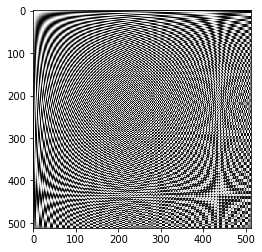

In [9]:
plt.imshow(dct_matrix(512), cmap='gray')
plt.show()
T = dct_matrix(512)

To test the new DCT method, the transform is applied to the image defined prior.  As we can see, the result is exactly the same, and thus retains the same bandpass properties.  The resulting difference is due to [inaccuracies in the numpy sum implementation.](https://stackoverflow.com/questions/33004029/is-numpy-sum-implemented-in-such-a-way-that-numerical-errors-are-avoided) 

Difference: 6.06954853871794e-06


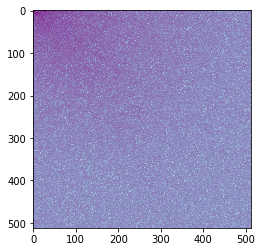

In [10]:
test2 = dct2(gray, 512)
plt.imshow(np.log(np.absolute(test2)), cmap='BuPu')
print("Difference:", np.sum(test2 - dct_img))
plt.show()

Furthemore, the `idct2` function works as intended.

Difference: 3.115031843581306e-11


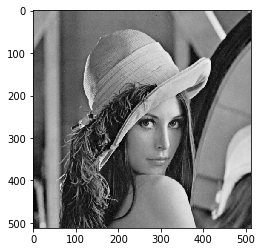

In [11]:
test_img = idct2(test2,512)
plt.imshow(test_img, cmap = 'gray')
print("Difference:", np.sum(gray - test_img))
plt.show()

#### JPEG

As noted earlier, the `dct2` and `idct2` functions were defined with the intention of partitioned transforms in mind.  JPEG works by splitting up the image into `8*8` segments and applying the DCT transform to each.  

Upon looking at the resulting values of each chunk, the coefficients of some of the basis functions are close to 0.  This indicates that these basis functions do not strongly define the chunk, and only provide very minor detail to the image.

JPEG works by setting these very small coefficient values to 0, making the assumption that their inclusion does not provide enough detail to the overall image.

This process is called **Quantization**.  First, we must apply the DCT to small `8x8` partitions along the entire image.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


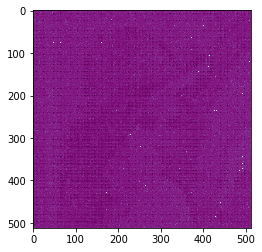

In [12]:
test2 = dct2(gray, 8)
plt.imshow(np.log(np.absolute(test2)), cmap='BuPu')
plt.show()

Without setting any of the coefficients to 0, the image is still the same as the original upon reconstruction. 

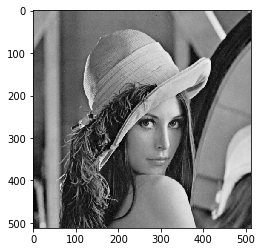

In [13]:
test_img = idct2(test2, 8)
plt.imshow(test_img, cmap = 'gray')
plt.show()

Next, lets set basis functions with intensities less than between `-0.01` and `0.01` to 0.  The reason for this range is due to the fact that the intensities can range from `-1` to `1`.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


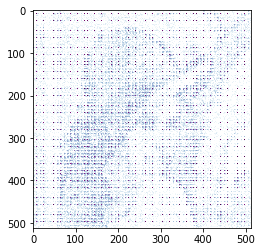

In [14]:
test2[np.absolute(test2) < 0.01] = 0
plt.imshow(np.log(np.absolute(test2)), cmap='BuPu')
plt.show()

It's *very* interesting to see that the high frequency data around the hair and other rejoins is very obviously outlined in the DCT.  Most DCTs will not have the original structure present, but due to the partitioning, a rough outline can be seen. Upon applying the inverse transform, the original image can be seen without a visible loss of fidelity.  However, the amount of data in the DCT is significantly less!

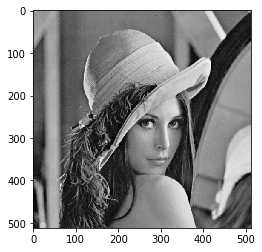

In [15]:
test_img = idct2(test2, 8)
plt.imshow(test_img, cmap = 'gray')
plt.show()

If we increase the range of data that is set to zero from `0.1` to `0.5`, we will be attenuating a larger portion of frequencies throughout the image.  This means that a significantly less amount of data is required to display the image.  However, the resulting image is visibly degraded!

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


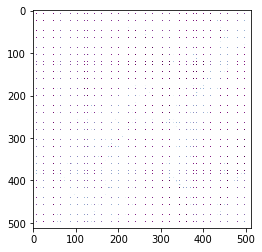

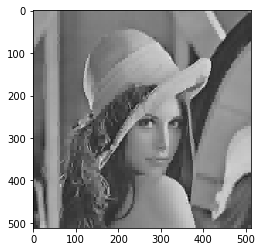

In [16]:
test2[np.absolute(test2) < 0.5] = 0
plt.imshow(np.log(np.absolute(test2)), cmap='BuPu')
plt.show()
test_img = idct2(test2, 8)
plt.imshow(test_img, cmap = 'gray')
plt.show()

#### Conclusion
A lot was learned about DCT, the implementations of DCT, and how it functions in its most famous application, JPEG. Although all DCT uses the same underlying math, the implementations of it, such as bandpass filters to partitioning, vary greatly.  

In addition, the implementation of the DCT function uses the dot product and matrix manipulation effectively providing an efficient and easy method.